In [1]:
import gym
import tensorflow as tf
import numpy as np

## Gym

In [2]:
env = gym.make('LunarLander-v2')

[2017-10-29 19:28:25,921] Making new env: LunarLander-v2


## Q-Network

In [3]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=8, 
                 action_size=4, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

In [4]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

In [5]:
train_episodes = 3000          # max number of episodes to learn from
max_steps = 2000                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob
#do_nothing_p = 0.2

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 1000                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

In [7]:
# Initialize the simulation
env.reset()

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()
    
    state, reward, done, _ = env.step(env.action_space.sample())

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

In [8]:
%%time
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            #env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
                #action = np.random.choice(range(env.action_space.n), p=[do_nothing_p, (1-do_nothing_p)/3, (1-do_nothing_p)/3, (1-do_nothing_p)/3])
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                finished_at = t
                next_state = np.zeros(state.shape)
                t = max_steps
                if ep % 10 == 0:
                    print('Episode: {}'.format(ep),
                          'Total reward: {}'.format(total_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Explore P: {:.4f}'.format(explore_p),
                          'Finished at: {}'.format(finished_at))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/lander.ckpt")

Episode: 10 Total reward: -204.05287956398962 Training loss: 31.9751 Explore P: 0.9908 Finished at: 58
Episode: 20 Total reward: -286.60643821381996 Training loss: 47.6679 Explore P: 0.9823 Finished at: 126
Episode: 30 Total reward: -142.38615887172014 Training loss: 88.5372 Explore P: 0.9748 Finished at: 81
Episode: 40 Total reward: -171.6818645953128 Training loss: 79.6918 Explore P: 0.9668 Finished at: 59
Episode: 50 Total reward: -259.885376803276 Training loss: 51.0813 Explore P: 0.9582 Finished at: 128
Episode: 60 Total reward: -28.84810836042341 Training loss: 51.2563 Explore P: 0.9483 Finished at: 84
Episode: 70 Total reward: -141.88122708759954 Training loss: 26.4784 Explore P: 0.9403 Finished at: 116
Episode: 80 Total reward: -227.73581808849042 Training loss: 56.8903 Explore P: 0.9312 Finished at: 103
Episode: 90 Total reward: -167.26500531094558 Training loss: 38.8842 Explore P: 0.9226 Finished at: 87
Episode: 100 Total reward: -175.86346818537004 Training loss: 64.8650 Exp

Episode: 800 Total reward: -212.69920285306165 Training loss: 7.7283 Explore P: 0.1513 Finished at: 175
Episode: 810 Total reward: 207.52324093884587 Training loss: 47.7608 Explore P: 0.1433 Finished at: 343
Episode: 820 Total reward: 177.799701772814 Training loss: 3.1630 Explore P: 0.1377 Finished at: 254
Episode: 830 Total reward: 192.37553994837083 Training loss: 3.6859 Explore P: 0.1329 Finished at: 333
Episode: 840 Total reward: 170.70620311391173 Training loss: 9.5778 Explore P: 0.1282 Finished at: 443
Episode: 850 Total reward: 94.06696701752838 Training loss: 29.1171 Explore P: 0.1234 Finished at: 998
Episode: 860 Total reward: 222.75515378020665 Training loss: 15.7954 Explore P: 0.1177 Finished at: 471
Episode: 870 Total reward: 82.6220337710559 Training loss: 30.6608 Explore P: 0.1123 Finished at: 998
Episode: 880 Total reward: 164.13051314900025 Training loss: 70.6228 Explore P: 0.1090 Finished at: 243
Episode: 890 Total reward: 249.82844004891717 Training loss: 28.4018 Exp

Episode: 1590 Total reward: 252.0030923993635 Training loss: 42.6871 Explore P: 0.0264 Finished at: 231
Episode: 1600 Total reward: 198.7261789577448 Training loss: 67.4910 Explore P: 0.0260 Finished at: 429
Episode: 1610 Total reward: 203.95504255772994 Training loss: 42.0897 Explore P: 0.0257 Finished at: 219
Episode: 1620 Total reward: 221.48890477297027 Training loss: 78.9811 Explore P: 0.0254 Finished at: 207
Episode: 1630 Total reward: 252.66587476682264 Training loss: 69.7520 Explore P: 0.0251 Finished at: 210
Episode: 1640 Total reward: 229.226602214163 Training loss: 20.4003 Explore P: 0.0247 Finished at: 230
Episode: 1650 Total reward: 252.13026567692717 Training loss: 82.8073 Explore P: 0.0244 Finished at: 219
Episode: 1660 Total reward: 236.74861976213734 Training loss: 79.2035 Explore P: 0.0240 Finished at: 156
Episode: 1670 Total reward: 219.44073428028017 Training loss: 77.0235 Explore P: 0.0237 Finished at: 169
Episode: 1680 Total reward: 2.2369296117844186 Training los

Episode: 2380 Total reward: 167.83272254203166 Training loss: 50.6144 Explore P: 0.0125 Finished at: 263
Episode: 2390 Total reward: 35.210056930949435 Training loss: 33.5524 Explore P: 0.0124 Finished at: 145
Episode: 2400 Total reward: 210.1370373221285 Training loss: 77.2217 Explore P: 0.0124 Finished at: 194
Episode: 2410 Total reward: -218.41671923182668 Training loss: 41.1719 Explore P: 0.0123 Finished at: 280
Episode: 2420 Total reward: 232.50701615370423 Training loss: 48.9881 Explore P: 0.0123 Finished at: 231
Episode: 2430 Total reward: 220.8197945086725 Training loss: 32.0853 Explore P: 0.0122 Finished at: 198
Episode: 2440 Total reward: 219.96158343710988 Training loss: 60.4865 Explore P: 0.0122 Finished at: 251
Episode: 2450 Total reward: 227.30361577915318 Training loss: 17.5807 Explore P: 0.0121 Finished at: 236
Episode: 2460 Total reward: 205.3203530412722 Training loss: 15.9619 Explore P: 0.0121 Finished at: 339
Episode: 2470 Total reward: 192.74986064902296 Training l

## Visualizing

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

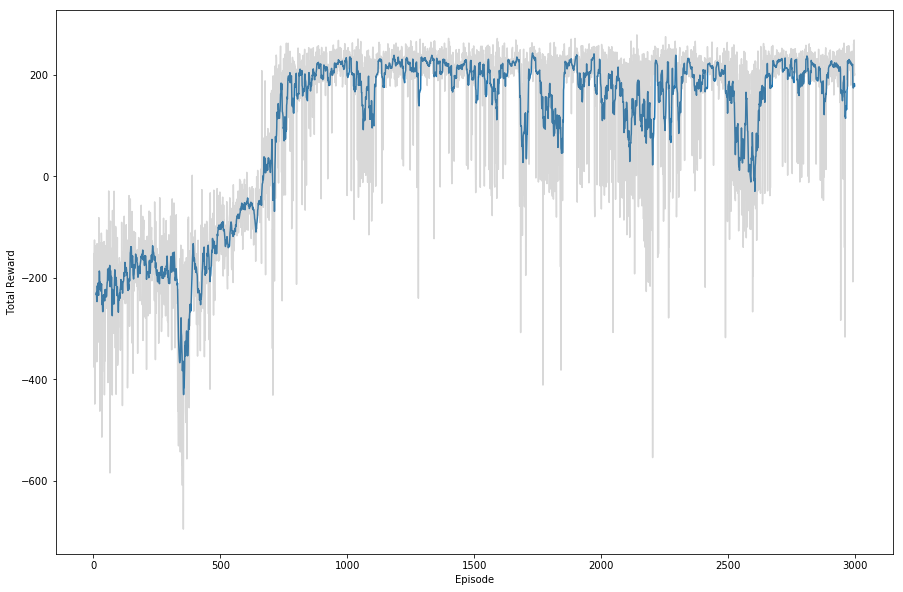

In [29]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

In [15]:
test_episodes = 100
test_max_steps = 1000
env.reset()

acc_rewards = []

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(test_episodes):
        sum_r = 0
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            sum_r += reward
            
            if done:
                t = test_max_steps
                env.reset()
            else:
                state = next_state
                t += 1
                
        acc_rewards.append(sum_r)

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


[2017-10-29 21:51:10,617] Restoring parameters from checkpoints/cartpole.ckpt


In [16]:
env.close()

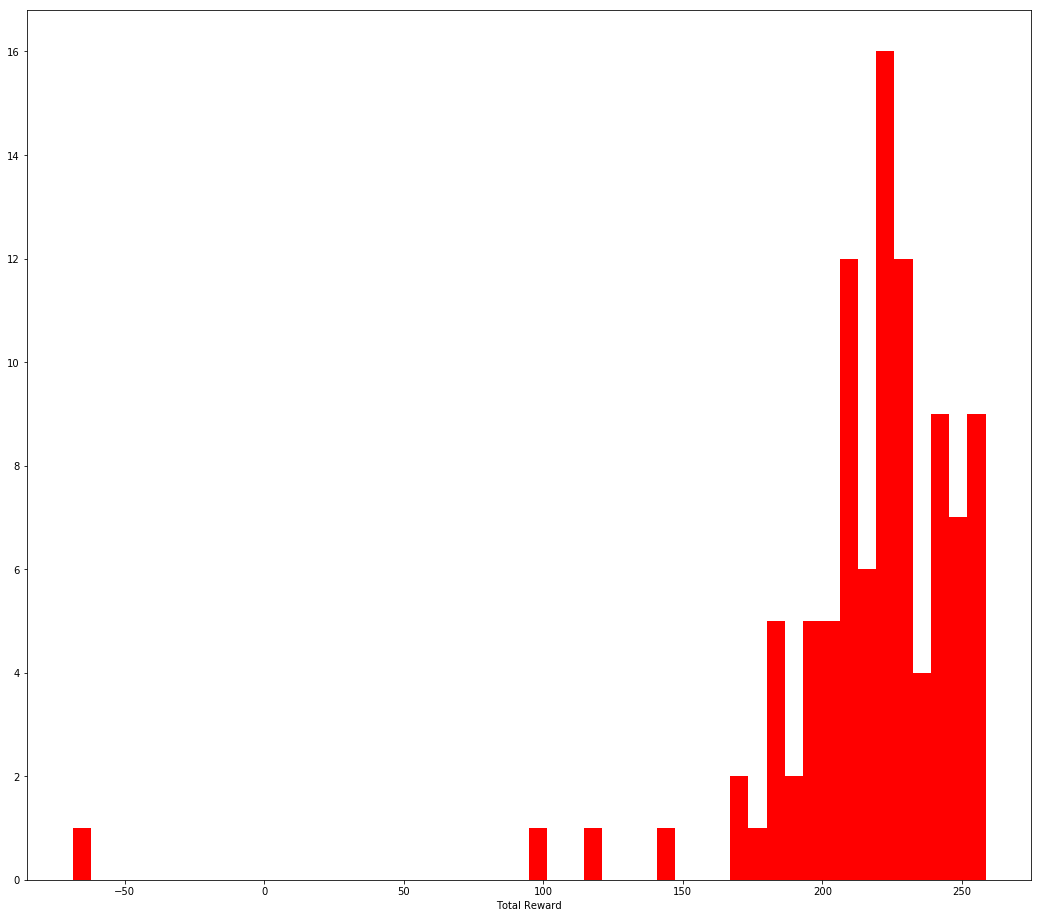

In [22]:
plt.hist(acc_rewards, color='red', bins=50)
plt.xlabel('Total Reward')

## Tuning hyperparameters

In [61]:
# Dynamic Parameters
gammas = [0.8, 0.9, .99]                   # future reward discount
decay_rates = [0.001, 0.0001, 0.00001]          # exponential decay rate for exploration prob
learning_rates = [0.01, 0.001, 0.0001]       # Q-network learning rate

# Static Parameters
max_steps = 400                # max steps in an episode
train_episodes = 1200          # max number of episodes to learn from

explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 

hidden_size = 64               # number of units in each Q-network hidden layer

memory_size = 10000            # memory capacity
batch_size = 100                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [59]:
# wrap all ops in functions
def create_net():
    tf.reset_default_graph()
    mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
    return mainQN
    
def train(net):
    mainQN = net
    
    # Initialize the simulation
    env.reset()

    memory = Memory(max_size=memory_size)

    # Make a bunch of random actions and store the experiences
    for ii in range(pretrain_length):
        # Uncomment the line below to watch the simulation
        # env.render()

        state, reward, done, _ = env.step(env.action_space.sample())

        # Make a random action
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)

        if done:
            # The simulation fails so no next state
            next_state = np.zeros(state.shape)
            # Add experience to memory
            memory.add((state, action, reward, next_state))

            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
    
    # Now train with experiences
    saver = tf.train.Saver()
    rewards_list = []
    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        step = 0
        for ep in range(1, train_episodes):
            total_reward = 0
            t = 0
            while t < max_steps:
                step += 1
                # Uncomment this next line to watch the training
                #env.render() 

                # Explore or Exploit
                explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
                if explore_p > np.random.rand():
                    # Make a random action
                    action = env.action_space.sample()
                else:
                    # Get action from Q-network
                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)

                total_reward += reward

                if done:
                    # the episode ends so no next state
                    finished_at = t
                    next_state = np.zeros(state.shape)
                    t = max_steps
                    if ep % 100 == 0:
                        print('Episode: {}'.format(ep),
                              'Total reward: {}'.format(total_reward),
                              'Training loss: {:.4f}'.format(loss),
                              'Explore P: {:.4f}'.format(explore_p),
                              'Finished at: {}'.format(finished_at))
                    rewards_list.append((ep, total_reward))

                    # Add experience to memory
                    memory.add((state, action, reward, next_state))

                    # Start new episode
                    env.reset()
                    # Take one random step to get the pole and cart moving
                    state, reward, done, _ = env.step(env.action_space.sample())

                else:
                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = next_state
                    t += 1

                # Sample mini-batch from memory
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                rewards = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])

                # Train network
                target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

                targets = rewards + gamma * np.max(target_Qs, axis=1)

                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs_: states,
                                               mainQN.targetQs_: targets,
                                               mainQN.actions_: actions})

        saver.save(sess, "checkpoints/lander_{}_{}_{}.ckpt".format(gamma, decay_rate, learning_rate))
        
        return rewards_list

def test(net):
    mainQN = net
    
    test_episodes = 100
    test_max_steps = 500
    state = env.reset()

    acc_rewards = []

    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

        for ep in range(test_episodes):
            sum_r = 0
            t = 0
            while t < test_max_steps:
                # env.render() 

                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)

                sum_r += reward

                if done:
                    t = test_max_steps
                    state = env.reset()
                else:
                    state = next_state
                    t += 1

            acc_rewards.append(sum_r)
    return acc_rewards

In [60]:
gamma_train_results = {}
gamma_test_results = {}
for gamma in gammas:
    decay_rate = 0.00001
    learning_rate = 0.0001
    print('Testing parameters: gamma={}, decay={}, learning_rate={}'.format(gamma, decay_rate, learning_rate))
    net = create_net()
    gamma_train_results[gamma] = train(net)
    gamma_test_results[gamma] = test(net)

Testing parameters: gamma=0.8, decay=1e-05, learning_rate=0.0001
Episode: 100 Total reward: -187.83245677953852 Training loss: 17.8756 Explore P: 0.9101 Finished at: 114
Episode: 200 Total reward: -164.89906541863672 Training loss: 42.0384 Explore P: 0.8224 Finished at: 94
Episode: 300 Total reward: -122.67247817004623 Training loss: 5.4177 Explore P: 0.7365 Finished at: 142
Episode: 400 Total reward: -128.46969281295375 Training loss: 12.7471 Explore P: 0.6473 Finished at: 90
Episode: 500 Total reward: -132.77930901281343 Training loss: 66.2026 Explore P: 0.5635 Finished at: 152
Episode: 700 Total reward: -50.61302147950718 Training loss: 7.0137 Explore P: 0.3614 Finished at: 131
Episode: 900 Total reward: 98.42254307055849 Training loss: 2.1595 Explore P: 0.2089 Finished at: 54
Episode: 1100 Total reward: -83.25142330894968 Training loss: 2.1485 Explore P: 0.1196 Finished at: 359
INFO:tensorflow:Restoring parameters from checkpoints/lander_0.8_1e-05_0.0001.ckpt


[2017-10-30 00:50:11,977] Restoring parameters from checkpoints/lander_0.8_1e-05_0.0001.ckpt


Testing parameters: gamma=0.9, decay=1e-05, learning_rate=0.0001
Episode: 100 Total reward: -164.41744179018048 Training loss: 14.1123 Explore P: 0.9097 Finished at: 113
Episode: 200 Total reward: -42.15660223090131 Training loss: 17.7072 Explore P: 0.8221 Finished at: 81
Episode: 300 Total reward: -90.67564771424645 Training loss: 18.8577 Explore P: 0.7349 Finished at: 169
Episode: 500 Total reward: -186.94625866661528 Training loss: 4.1664 Explore P: 0.5502 Finished at: 304
Episode: 700 Total reward: -16.403844012887724 Training loss: 2.2054 Explore P: 0.3504 Finished at: 198
Episode: 1000 Total reward: -32.27839869459577 Training loss: 0.9895 Explore P: 0.1404 Finished at: 198
Episode: 1100 Total reward: -34.0849339255965 Training loss: 0.7121 Explore P: 0.1033 Finished at: 198
INFO:tensorflow:Restoring parameters from checkpoints/lander_0.9_1e-05_0.0001.ckpt


[2017-10-30 01:05:03,242] Restoring parameters from checkpoints/lander_0.9_1e-05_0.0001.ckpt


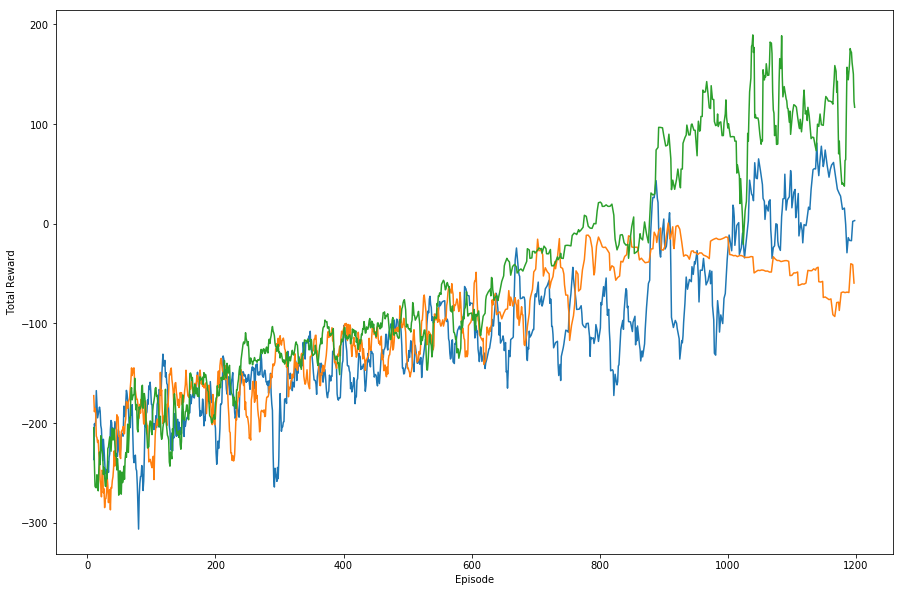

In [67]:
for gamma in gammas:
    rewards_list = gamma_train_results[gamma]
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, 10)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

In [64]:
dr_train_results = {}
dr_test_results = {}
for decay_rate in decay_rates:
    gamma = 0.99
    learning_rate = 0.0001
    print('Testing parameters: gamma={}, decay={}, learning_rate={}'.format(gamma, decay_rate, learning_rate))
    net = create_net()
    dr_train_results[decay_rate] = train(net)
    dr_test_results[decay_rate] = test(net)

Testing parameters: gamma=0.99, decay=0.001, learning_rate=0.0001
Episode: 200 Total reward: -43.730750789099375 Training loss: 0.5920 Explore P: 0.0100 Finished at: 198
Episode: 600 Total reward: -42.12443061849447 Training loss: 0.4222 Explore P: 0.0100 Finished at: 198
Episode: 800 Total reward: -45.84985523067156 Training loss: 0.4119 Explore P: 0.0100 Finished at: 198
Episode: 1000 Total reward: -36.058964227471115 Training loss: 0.5956 Explore P: 0.0100 Finished at: 198
INFO:tensorflow:Restoring parameters from checkpoints/lander_0.99_0.001_0.0001.ckpt


[2017-10-30 01:43:30,359] Restoring parameters from checkpoints/lander_0.99_0.001_0.0001.ckpt


Testing parameters: gamma=0.99, decay=0.0001, learning_rate=0.0001
Episode: 100 Total reward: -360.0795707665293 Training loss: 1132.7561 Explore P: 0.2756 Finished at: 320
Episode: 500 Total reward: -24.189917852768858 Training loss: 0.4761 Explore P: 0.0100 Finished at: 198
INFO:tensorflow:Restoring parameters from checkpoints/lander_0.99_0.0001_0.0001.ckpt


[2017-10-30 02:06:05,186] Restoring parameters from checkpoints/lander_0.99_0.0001_0.0001.ckpt


Testing parameters: gamma=0.99, decay=1e-05, learning_rate=0.0001
Episode: 100 Total reward: -249.05352105652906 Training loss: 5.7040 Explore P: 0.9106 Finished at: 108
Episode: 200 Total reward: -126.60996497024385 Training loss: 15.0671 Explore P: 0.8226 Finished at: 114
Episode: 300 Total reward: -70.14536807608022 Training loss: 18.8728 Explore P: 0.7362 Finished at: 139
Episode: 400 Total reward: -111.17591346304799 Training loss: 9.5289 Explore P: 0.6423 Finished at: 116
Episode: 500 Total reward: -88.63464004495621 Training loss: 2.9934 Explore P: 0.5631 Finished at: 140
Episode: 600 Total reward: -83.13173702311228 Training loss: 15.1150 Explore P: 0.4808 Finished at: 74
Episode: 800 Total reward: 231.73990345257752 Training loss: 2.0419 Explore P: 0.2829 Finished at: 294
Episode: 900 Total reward: -3.2565073398130693 Training loss: 12.7379 Explore P: 0.2125 Finished at: 212
Episode: 1000 Total reward: -18.654351709070927 Training loss: 4.8417 Explore P: 0.1604 Finished at: 19

[2017-10-30 02:20:07,904] Restoring parameters from checkpoints/lander_0.99_1e-05_0.0001.ckpt


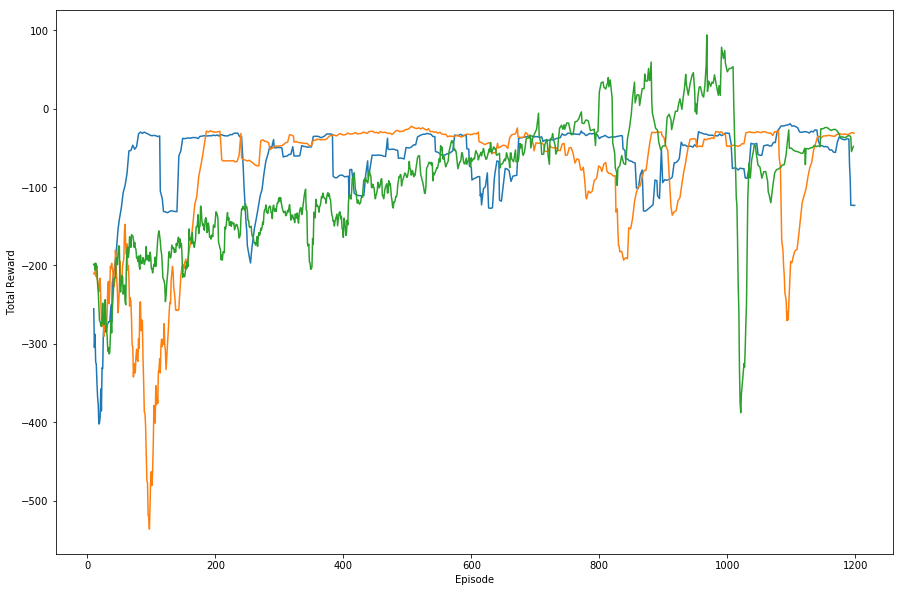

In [69]:
for dr in decay_rates:
    rewards_list = dr_train_results[dr]
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, 10)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

In [76]:
lr_train_results = {}
lr_test_results = {}
for learning_rate in learning_rates:
    gamma = 0.99
    decay_rate = 0.00001
    print('Testing parameters: gamma={}, decay={}, learning_rate={}'.format(gamma, decay_rate, learning_rate))
    net = create_net()
    lr_train_results[learning_rate] = train(net)
    lr_test_results[learning_rate] = test(net)

Testing parameters: gamma=0.99, decay=1e-05, learning_rate=0.01
Episode: 100 Total reward: -15.112047549183828 Training loss: nan Explore P: 0.9123 Finished at: 83
Episode: 200 Total reward: -156.89355136298065 Training loss: nan Explore P: 0.8346 Finished at: 85
Episode: 300 Total reward: -139.999809831821 Training loss: nan Explore P: 0.7655 Finished at: 77
Episode: 400 Total reward: -180.31800750940852 Training loss: nan Explore P: 0.7040 Finished at: 59
Episode: 500 Total reward: -221.092280597186 Training loss: nan Explore P: 0.6474 Finished at: 63
Episode: 600 Total reward: -151.63049308240298 Training loss: nan Explore P: 0.5975 Finished at: 61
Episode: 700 Total reward: -341.63237272445457 Training loss: nan Explore P: 0.5480 Finished at: 91
Episode: 800 Total reward: -155.6549908555732 Training loss: nan Explore P: 0.5084 Finished at: 67
Episode: 900 Total reward: -181.25883917110207 Training loss: nan Explore P: 0.4712 Finished at: 56
Episode: 1000 Total reward: -136.88447063

[2017-10-30 03:34:40,391] Restoring parameters from checkpoints/lander_0.99_1e-05_0.01.ckpt


Testing parameters: gamma=0.99, decay=1e-05, learning_rate=0.001
Episode: 100 Total reward: -303.55031433034424 Training loss: 3418102956032.0000 Explore P: 0.9145 Finished at: 91
Episode: 200 Total reward: -639.131474476003 Training loss: 159293642899456.0000 Explore P: 0.8269 Finished at: 135
Episode: 300 Total reward: -256.1167636037426 Training loss: 260826233569280.0000 Explore P: 0.7471 Finished at: 102
Episode: 400 Total reward: -207.3509628736084 Training loss: 10161869000015872.0000 Explore P: 0.6665 Finished at: 106
Episode: 500 Total reward: -386.764681744901 Training loss: 471626399350784.0000 Explore P: 0.5917 Finished at: 95
Episode: 600 Total reward: -482.356501310746 Training loss: 167208546205696.0000 Explore P: 0.5177 Finished at: 151
Episode: 700 Total reward: -330.7447214397362 Training loss: 58056717107200.0000 Explore P: 0.4560 Finished at: 138
Episode: 800 Total reward: -154.25745823649314 Training loss: 21609922428928.0000 Explore P: 0.4016 Finished at: 53
Episo

[2017-10-30 03:40:25,667] Restoring parameters from checkpoints/lander_0.99_1e-05_0.001.ckpt


Testing parameters: gamma=0.99, decay=1e-05, learning_rate=0.0001
Episode: 100 Total reward: -288.668894186143 Training loss: 105.3649 Explore P: 0.9144 Finished at: 112
Episode: 200 Total reward: -130.68019854931072 Training loss: 3.7259 Explore P: 0.8300 Finished at: 104
Episode: 300 Total reward: -114.91419120699072 Training loss: 8.4874 Explore P: 0.7459 Finished at: 77
Episode: 400 Total reward: -79.9561381320701 Training loss: 9.7897 Explore P: 0.6611 Finished at: 94
Episode: 500 Total reward: -103.94322111265058 Training loss: 5.4153 Explore P: 0.5745 Finished at: 182
Episode: 600 Total reward: -65.12280760749687 Training loss: 20.3994 Explore P: 0.4737 Finished at: 65
Episode: 1000 Total reward: -63.95281639686688 Training loss: 5.2507 Explore P: 0.1566 Finished at: 64
INFO:tensorflow:Restoring parameters from checkpoints/lander_0.99_1e-05_0.0001.ckpt


[2017-10-30 03:52:40,638] Restoring parameters from checkpoints/lander_0.99_1e-05_0.0001.ckpt


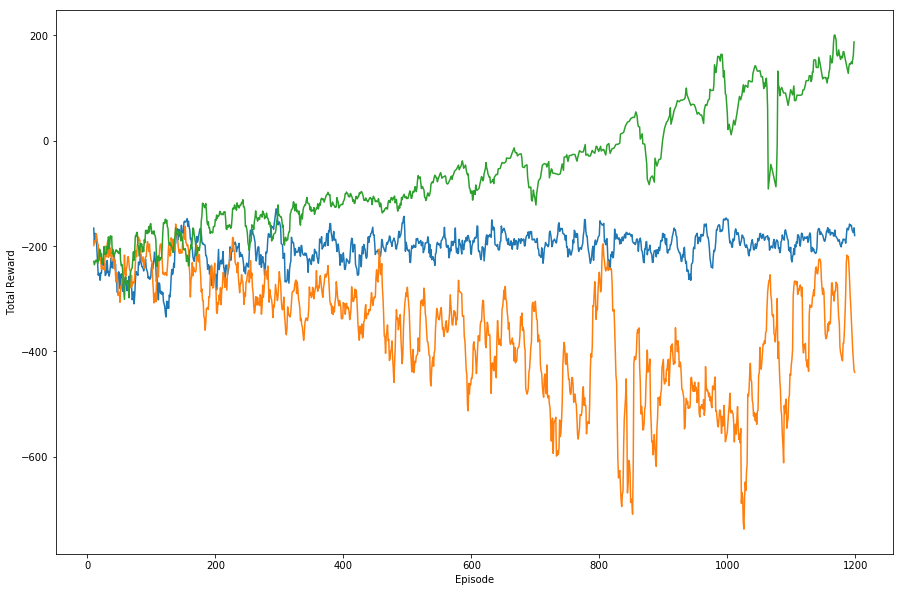

In [77]:
for lr in learning_rates:
    rewards_list = lr_train_results[lr]
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, 10)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')